In [1]:
library(tidyverse)
library(ggplot2)
library(broom)
library(knitr)
options(repr.matrix.max.rows = 20)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



### 2. Pre-processing - Simon

In [2]:
bee_df <- read.csv("https://files.ontario.ca/moe_mapping/downloads/4Other/PHAP/Bumble_Bee_Public_Data.csv") |>
    select(1:7, contains("total")) |>
    mutate(site_type = case_when(`Site.Type` == "Agri" ~ "Agricultural",
                                 `Site.Type` == "Agriculture" ~ "Agricultural",
                                 TRUE ~ `Site.Type`)) |>
    rename(
        county = `ï..County`,
        site_id = `MOECC.Site.Number`,
        year = Year,
        sample_date = `Sample.date`) |>
    filter(site_type != "") |>
    pivot_longer(`bimaculatus.total`:`flavidus.total`,
                 values_to = "no_of_bees", names_to = "species") |>
    select(county, year, site_id, site_type, no_of_bees, sample_date)

head(bee_df)

county,year,site_id,site_type,no_of_bees,sample_date
<chr>,<int>,<int>,<chr>,<int>,<chr>
Middlesex Centre,2015,1,Agricultural,7,07/02/2015
Middlesex Centre,2015,1,Agricultural,1,07/02/2015
Middlesex Centre,2015,1,Agricultural,3,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015
Middlesex Centre,2015,1,Agricultural,1,07/02/2015
Middlesex Centre,2015,1,Agricultural,0,07/02/2015


### 3. EDA - John

In [3]:
glimpse(bee_df)

Rows: 3,444
Columns: 6
$ county      <chr> "Middlesex Centre", "Middlesex Centre", "Middlesex Centre"~
$ year        <int> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015~
$ site_id     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2~
$ site_type   <chr> "Agricultural", "Agricultural", "Agricultural", "Agricultu~
$ no_of_bees  <int> 7, 1, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 14, 7, 0, 0, ~
$ sample_date <chr> "07/02/2015", "07/02/2015", "07/02/2015", "07/02/2015", "0~


In [4]:
bee_summary <- bee_df |>
    group_by(site_type) |>
    tally() |>
    rename(no_of_records = n)

kable(bee_summary, caption = "Table 1. Count of records per site")



Table: Table 1. Count of records per site

|site_type            | no_of_records|
|:--------------------|-------------:|
|Agricultural         |          1806|
|Natural              |           658|
|Semi-natural remnant |           980|

Warning message:
"Removed 1386 rows containing missing values (geom_point)."


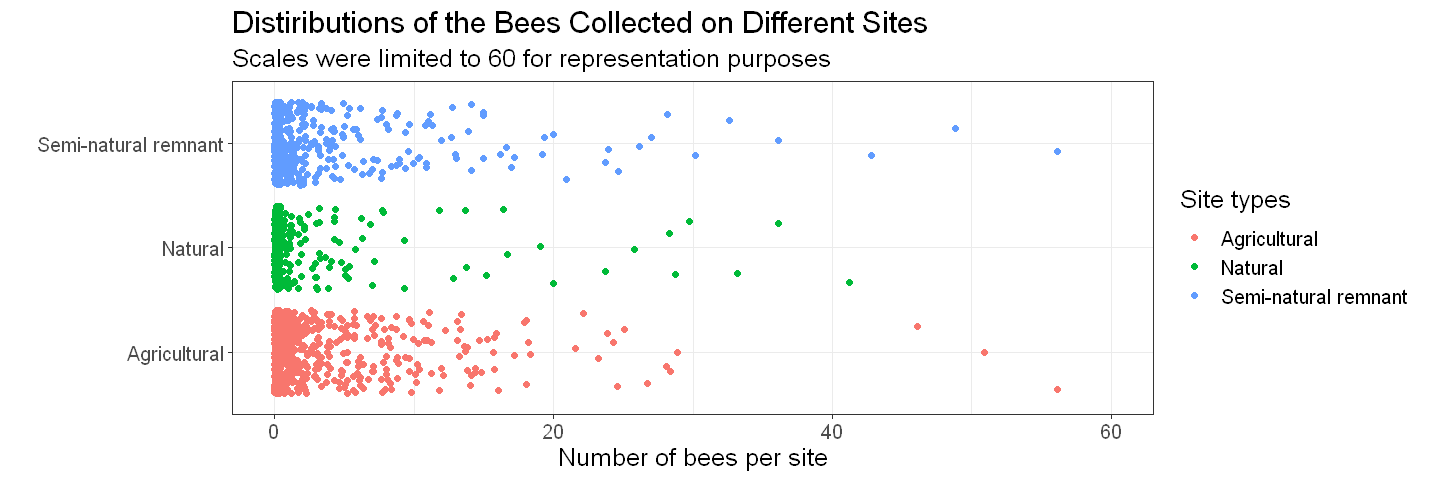

In [5]:
options(repr.plot.width=12, repr.plot.height=4)

bee_df_jitter <- ggplot(bee_df) +
    aes(y = site_type,
        x = no_of_bees,
        color = site_type) +
    geom_jitter() +
    labs(x = "Number of bees per site",
         y = "",
         color = "Site types",
         title = "Distiributions of the Bees Collected on Different Sites",
         subtitle = "Scales were limited to 60 for representation purposes"
         ) +
    scale_x_continuous(limits = c(0, 60)) +
    guides(fill = "none") +
    theme_bw() +
    theme(text =  element_text(size = 15))

bee_df_jitter
#ggsave("bee_df_jitter.png")

### 4. Analysis - Katia

In [6]:
bee_df <- bee_df |>
    mutate(site_type = as.factor(site_type))

pois_lr_agri <- glm(no_of_bees ~ relevel(site_type, ref = "Agricultural"),
               family = poisson,
               data = bee_df)

pois_lr_natural <- glm(no_of_bees ~ relevel(site_type, ref = "Natural"),
               family = poisson,
               data = bee_df)

### 5. Statistical summary tables - Adrienne

In [7]:
agri_table <- tidy(pois_lr_agri)
nat_table <- tidy(pois_lr_natural)

pairs <- c("Agricultural vs natural",
           "Agricultural vs semi-natural remnant",
           "Natural vs agricultural",
           "Natural vs semi-natural remnant")

analysis_table <- rbind(agri_table, nat_table) |>
    filter(term != "(Intercept)") |>
    mutate(p_rounded = round(`p.value`, 3),
           pairs = case_when(
               term == 'relevel(site_type, ref = "Agricultural")Natural' ~ "Agricultural vs natural",
               term == 'relevel(site_type, ref = "Agricultural")Semi-natural remnant' ~ "Agricultural vs semi-natural remnant",
               term == 'relevel(site_type, ref = "Natural")Agricultural' ~ "Natural vs agricultural",
               term == 'relevel(site_type, ref = "Natural")Semi-natural remnant' ~ "Natural vs semi-natural remnant")) |>
    relocate(pairs, .before = estimate) |>
    select(-term)

kable(analysis_table, caption = "Table 2. Analysis results")



Table: Table 2. Analysis results

|pairs                                |   estimate| std.error| statistic|   p.value| p_rounded|
|:------------------------------------|----------:|---------:|---------:|---------:|---------:|
|Agricultural vs natural              |  0.0759158| 0.0409905|  1.852033| 0.0640210|     0.064|
|Agricultural vs semi-natural remnant |  0.2001459| 0.0344886|  5.803244| 0.0000000|     0.000|
|Natural vs agricultural              | -0.0759158| 0.0409905| -1.852033| 0.0640210|     0.064|
|Natural vs semi-natural remnant      |  0.1242301| 0.0438334|  2.834140| 0.0045949|     0.005|